## Objective

**<ins>Target</ins>**

Try out different normalizations methods and analyze which performs better
- _Batch Normalizaiton_
- _Layer Normalization_
- _Group Normalization_
- _Instance Normalization_

Also use _L1_ and _L2_ talong with the normalization methods and tabulate the findings


**<ins>Inference</ins>**

- Based on the plots on [accuracies](#acc_with_in) and [loss](#loss_with_in) comparing Batch, Group, Layer and Instance Normalizaiton, we see instance normalization underperfoming as compared to the other normalization methods
- Comparing the [accuracies](#acc_wo_in) and [loss](#loss_wo_in) of Batch, Group and Layer Normalization (i.e. without Instance Norm), the best accuracy (and correspondingly the least loss) is seen while using _Group Normalization_, followed by Batch Norm and then Layer Norm
    - Although they perform equally well (with a margin of 1-1.5% variation in accuracy), the effect could be due to the difference in regularization methods used
- Training setup used the same [model architecture](./model.py) with the following changes
    - For BN, both L1 and L2 Regularization was used along with a dropout of 0.01
    - For GN, L1 Regularization was used along with a dropout of 0.01
    - For LN, L2 Regularization was use along with a dropout of 0.01
    - For IN, both L1 and L2 Regularization was used along with a dropout of 0.01
- The misclassified images for each of the models are shown in their corresponding sections; In these images, the digits are missing portions or its hard to read.
    - [Misclassified Images - Batch Norm](#bn_miss_img)
    - [Misclassified Images - Group Norm](#gn_miss_img)
    - [Misclassified Images - Layer Norm](#ln_miss_img)
    - [Misclassified Images - Instance Norm](#in_miss_img)

<sub><em> Note: Instance Norm isn't part of the requirements, but explored here for better understanding </em></sub>

## Imports

In [1]:
# PyTorch, everything from PyTorch can be referred with this
import torch

# Import the neural network model seperately
import torch.nn as nn

# Contains functions that are required such as ReLu (Activation function)
import torch.nn.functional as F 

# Optimizers required to converge using Backpropogation
import torch.optim as optim

# Datasets are used to download and load the data
# used to train and validate
# Transforms can be used to define modifications and/or augmentations methods
# to be applied while passing the data
# Normalization can also be one of the compositions of transforms
import torchvision
from torchvision import datasets, transforms

# Dataset abstract class using which custom dataset classes can be created
# DataLoader to create batches and to shuffle the data
from torch.utils.data import Dataset, DataLoader

# Visualize the images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid # ImageGrid to form a grid of images

# Utils
import cv2
import numpy as np
import seaborn as sns
from importlib import reload # Used to reload the functions
from collections import OrderedDict

In [2]:
# Disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### Mount Google Drive to access the files
This is not required while running locally

In [3]:
# Mount the contents from google drive
from google.colab import drive
drive.mount('/gdrive')

# Create a directory
!mkdir "/content/dependencies/"

# Create a symlink to the current directory
!ln -s "/gdrive/My Drive/Colab Notebooks/EVA6/Assi 6/" "/content/dependencies/"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
mkdir: cannot create directory ‘/content/dependencies/’: File exists
ln: failed to create symbolic link '/content/dependencies/Assi 6': File exists


In [4]:
# Add the path to the system path, so that
# the functions/classes within the files can be imported
import sys
sys.path.append ("/content/dependencies/Assi 6/")

## Load the data
Define the data loaders for train and test with $batch\_size = 128$.

In [5]:
# Seed the random generator used by PyTorch
# so that the results are reproduceable
torch.manual_seed(1)

# Define the batch size to be used
# i.e. the number of images to be used per batch
batch_size = 128

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Parameters to be used while loading the data
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Import the function to load the training
# and the test data loaders
# Reload updates the functions if any changes are made
# instead of having to restart the kernel each time
import utils; reload (utils)

# Get the train and test loaders
train_loader, test_loader = utils.load_train_test (
    mode='both', # Mode indicates whether train/test is required
    additional_transforms=[
        transforms.RandomRotation (6.9),
        #RandomErosion ((2, 2)),
        #RandomDilation ((2, 2))
    ],
    batch_size=batch_size, 
    **kwargs
)

In [6]:
print (f'No. of training batches: {len (train_loader)}\nNo. of test batches: {len (test_loader)}')

No. of training batches: 469
No. of test batches: 79


## Log the results from different models

In [7]:
# Log the results for each of the models
model_logs = {
    'batch_norm': {},
    'group_norm': {},
    'layer_norm': {},
    'instance_norm': {}
}

## Model using Batch Normalization
Batch Normalization with L1 and L2 Regularization

|![batch_norm](../../Images/markdown_images/batch_norm.png)|
|:---:|
|_Batch Normalization[1](#references)_|

In [8]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
from torchsummary import summary

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the dropout_percentage
dropout_percentage = 0.01

# Normalization strategy
# one of 'group_norm', 'layer_norm', 
# 'batch_norm' or 'instance_norm'
# Tying out instance norm just to see how it works
normalization = 'batch_norm'

# Import the class with the network architecture
import model; reload (model)

# Create a model object
custom_model = model.MNISTNet (
    drop_perc=dropout_percentage,
    normalization=normalization
).to (device)
summary(custom_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]             128
            Conv2d-6            [-1, 8, 24, 24]             576
       BatchNorm2d-7            [-1, 8, 24, 24]              16
              ReLU-8            [-1, 8, 24, 24]               0
           Dropout-9            [-1, 8, 24, 24]               0
           Conv2d-10           [-1, 16, 24, 24]           1,152
      BatchNorm2d-11           [-1, 16, 24, 24]              32
             ReLU-12           [-1, 16, 24, 24]               0
          Dropout-13           [-1, 16, 24, 24]               0
        MaxPool2d-14           [-1, 16,

### Train and Validate

In [9]:
# Initialize the model instance
custom_model = model.MNISTNet(
    drop_perc=dropout_percentage,
    normalization=normalization
).to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 

# Have the learning rate initially so that it gets to the region of the global minima
# faster and then reduce it so the it converges slowly to the required minima
# This should avoid falling into local minima
optimizer = optim.SGD (custom_model.parameters(), lr=0.04, momentum=0.9)

# Define a learning rate scheduler
# Refered from: https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
# and https://pytorch.org/docs/master/optim.html
# https://pytorch.org/docs/master/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
# Decrease the learning rate after a particular step
plat_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', 
    factor=0.8, patience=1, 
    min_lr=0.0001, threshold=0.001, 
    verbose=True)

# Reduce the Learning Rate at the specified iteration
# Choose this is based on the previous runs
multistep_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[25], 
    gamma=0.05, verbose=True)

# Train the model for n epochs
epochs = 25

# Regularization
# Either 'None', 'l1', 'l2' or 'l1_l2'
regularization = 'l1_l2'
l1_lambda = 0.0001
l2_lambda = 0.001

# Store the training accuracy and losses
training_accuracy = []
training_losses = []

# Store the test accuracy and losses
test_accuracy = []
test_losses = []

for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    accuracy, loss, _ = model.train (
        custom_model, device, 
        train_loader, optimizer,
        scheduler=multistep_scheduler,
        regularization=regularization, # Regularization
        l1_lambda=l1_lambda, l2_lambda=l2_lambda # L1 and L2 lambdas
    )
    
    # Add it to the list
    # Accuracy and losses on the entire training set
    # at the end of all the batches
    training_accuracy.append (accuracy)
    training_losses.append (loss)

    # Validate the results on the test/validation set
    accuracy, loss, misclassified_images = model.test (
        custom_model, 
        device, 
        test_loader
    )

    # Add it to the list
    # The accuracy and loss are computed on the entire
    # test data, so will return a single value
    test_accuracy.append (accuracy)
    test_losses.append (loss)

    # Reduce the learning rate if the loss has plateaued
    plat_scheduler.step (loss)

print (f'Best Model had a Training Accuracy of {np.max (training_accuracy):.2f}', 
        f'& a Test Accuracy of {np.max (test_accuracy):.2f}')

# Update the model log
model_logs [normalization] ['misclassified_images'] = misclassified_images
model_logs [normalization] ['training_accuracy'] = training_accuracy
model_logs [normalization] ['training_losses'] = training_losses
model_logs [normalization] ['test_accuracy'] = test_accuracy
model_logs [normalization] ['test_losses'] = test_losses

  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0000e-02.
Iteration 1


Loss=0.3182; Accuracy=90.11; Learning Rate=0.0400: 100%|██████████| 469/469 [00:33<00:00, 14.21it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.0999; Accuracy=58607/60000 (97.68%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0821; Accuracy=9818/10000 (98.18%)


Iteration 2


Loss=0.2996; Accuracy=97.73; Learning Rate=0.0400: 100%|██████████| 469/469 [00:33<00:00, 14.07it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.1174; Accuracy=58082/60000 (96.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0904; Accuracy=9759/10000 (97.59%)


Iteration 3


Loss=0.3041; Accuracy=97.82; Learning Rate=0.0400: 100%|██████████| 469/469 [00:33<00:00, 14.01it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.1418; Accuracy=57746/60000 (96.24%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1171; Accuracy=9685/10000 (96.85%)


Epoch     3: reducing learning rate of group 0 to 3.2000e-02.
Iteration 4


Loss=0.1946; Accuracy=98.09; Learning Rate=0.0320: 100%|██████████| 469/469 [00:33<00:00, 14.04it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.1129; Accuracy=58391/60000 (97.32%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0899; Accuracy=9795/10000 (97.95%)


Iteration 5


Loss=0.2266; Accuracy=98.02; Learning Rate=0.0320: 100%|██████████| 469/469 [00:33<00:00, 13.97it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.0763; Accuracy=58784/60000 (97.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0553; Accuracy=9857/10000 (98.57%)


Iteration 6


Loss=0.2339; Accuracy=98.08; Learning Rate=0.0320: 100%|██████████| 469/469 [00:33<00:00, 14.09it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.1173; Accuracy=58042/60000 (96.74%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1040; Accuracy=9709/10000 (97.09%)


Iteration 7


Loss=0.2311; Accuracy=98.06; Learning Rate=0.0320: 100%|██████████| 469/469 [00:33<00:00, 13.88it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.1543; Accuracy=57531/60000 (95.89%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1263; Accuracy=9651/10000 (96.51%)


Epoch     7: reducing learning rate of group 0 to 2.5600e-02.
Iteration 8


Loss=0.2013; Accuracy=98.33; Learning Rate=0.0256: 100%|██████████| 469/469 [00:33<00:00, 13.86it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.0588; Accuracy=59111/60000 (98.52%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0510; Accuracy=9867/10000 (98.67%)


Iteration 9


Loss=0.1985; Accuracy=98.23; Learning Rate=0.0256: 100%|██████████| 469/469 [00:34<00:00, 13.79it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.0675; Accuracy=58846/60000 (98.08%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0532; Accuracy=9854/10000 (98.54%)


Iteration 10


Loss=0.2011; Accuracy=98.22; Learning Rate=0.0256: 100%|██████████| 469/469 [00:34<00:00, 13.76it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.0738; Accuracy=58898/60000 (98.16%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0558; Accuracy=9871/10000 (98.71%)


Epoch    10: reducing learning rate of group 0 to 2.0480e-02.
Iteration 11


Loss=0.1970; Accuracy=98.21; Learning Rate=0.0205: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.0869; Accuracy=58565/60000 (97.61%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0745; Accuracy=9788/10000 (97.88%)


Iteration 12


Loss=0.2003; Accuracy=98.37; Learning Rate=0.0205: 100%|██████████| 469/469 [00:33<00:00, 13.92it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.0710; Accuracy=58983/60000 (98.31%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0620; Accuracy=9846/10000 (98.46%)


Epoch    12: reducing learning rate of group 0 to 1.6384e-02.
Iteration 13


Loss=0.1537; Accuracy=98.51; Learning Rate=0.0164: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]

Adjusting learning rate of group 0 to 1.6384e-02.



Train set: Loss=0.0667; Accuracy=59014/60000 (98.36%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0549; Accuracy=9872/10000 (98.72%)


Iteration 14


Loss=0.2070; Accuracy=98.47; Learning Rate=0.0164: 100%|██████████| 469/469 [00:33<00:00, 14.09it/s]

Adjusting learning rate of group 0 to 1.6384e-02.



Train set: Loss=0.0632; Accuracy=58980/60000 (98.30%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0514; Accuracy=9866/10000 (98.66%)


Epoch    14: reducing learning rate of group 0 to 1.3107e-02.
Iteration 15


Loss=0.2070; Accuracy=98.66; Learning Rate=0.0131: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]

Adjusting learning rate of group 0 to 1.3107e-02.



Train set: Loss=0.0802; Accuracy=58701/60000 (97.83%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0756; Accuracy=9801/10000 (98.01%)


Iteration 16


Loss=0.1362; Accuracy=98.50; Learning Rate=0.0131: 100%|██████████| 469/469 [00:33<00:00, 13.86it/s]

Adjusting learning rate of group 0 to 1.3107e-02.



Train set: Loss=0.0761; Accuracy=58844/60000 (98.07%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0683; Accuracy=9816/10000 (98.16%)


Epoch    16: reducing learning rate of group 0 to 1.0486e-02.
Iteration 17


Loss=0.1269; Accuracy=98.69; Learning Rate=0.0105: 100%|██████████| 469/469 [00:34<00:00, 13.73it/s]

Adjusting learning rate of group 0 to 1.0486e-02.



Train set: Loss=0.0534; Accuracy=59221/60000 (98.70%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0462; Accuracy=9884/10000 (98.84%)


Iteration 18


Loss=0.1559; Accuracy=98.72; Learning Rate=0.0105: 100%|██████████| 469/469 [00:33<00:00, 13.90it/s]

Adjusting learning rate of group 0 to 1.0486e-02.



Train set: Loss=0.0567; Accuracy=59329/60000 (98.88%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0478; Accuracy=9900/10000 (99.00%)


Iteration 19


Loss=0.1560; Accuracy=98.56; Learning Rate=0.0105: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]

Adjusting learning rate of group 0 to 1.0486e-02.



Train set: Loss=0.0599; Accuracy=59107/60000 (98.51%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0513; Accuracy=9869/10000 (98.69%)


Epoch    19: reducing learning rate of group 0 to 8.3886e-03.
Iteration 20


Loss=0.1902; Accuracy=98.71; Learning Rate=0.0084: 100%|██████████| 469/469 [00:34<00:00, 13.76it/s]

Adjusting learning rate of group 0 to 8.3886e-03.



Train set: Loss=0.0411; Accuracy=59356/60000 (98.93%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0362; Accuracy=9907/10000 (99.07%)


Iteration 21


Loss=0.1573; Accuracy=98.79; Learning Rate=0.0084: 100%|██████████| 469/469 [00:34<00:00, 13.76it/s]

Adjusting learning rate of group 0 to 8.3886e-03.



Train set: Loss=0.0496; Accuracy=59247/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0419; Accuracy=9889/10000 (98.89%)


Iteration 22


Loss=0.1443; Accuracy=98.71; Learning Rate=0.0084: 100%|██████████| 469/469 [00:34<00:00, 13.74it/s]

Adjusting learning rate of group 0 to 8.3886e-03.



Train set: Loss=0.0439; Accuracy=59376/60000 (98.96%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0370; Accuracy=9907/10000 (99.07%)


Epoch    22: reducing learning rate of group 0 to 6.7109e-03.
Iteration 23


Loss=0.1298; Accuracy=98.86; Learning Rate=0.0067: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]

Adjusting learning rate of group 0 to 6.7109e-03.



Train set: Loss=0.0585; Accuracy=59154/60000 (98.59%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0508; Accuracy=9865/10000 (98.65%)


Iteration 24


Loss=0.1638; Accuracy=98.79; Learning Rate=0.0067: 100%|██████████| 469/469 [00:33<00:00, 13.85it/s]

Adjusting learning rate of group 0 to 6.7109e-03.



Train set: Loss=0.0504; Accuracy=59311/60000 (98.85%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0403; Accuracy=9911/10000 (99.11%)


Epoch    24: reducing learning rate of group 0 to 5.3687e-03.
Iteration 25


Loss=0.1414; Accuracy=98.88; Learning Rate=0.0054: 100%|██████████| 469/469 [00:33<00:00, 14.04it/s]

Adjusting learning rate of group 0 to 2.6844e-04.



Train set: Loss=0.0396; Accuracy=59386/60000 (98.98%)



Test set: Loss=0.0355; Accuracy=9915/10000 (99.15%)


Best Model had a Training Accuracy of 98.98 & a Test Accuracy of 99.15


### Plot Results

#### Accuracy and Losses

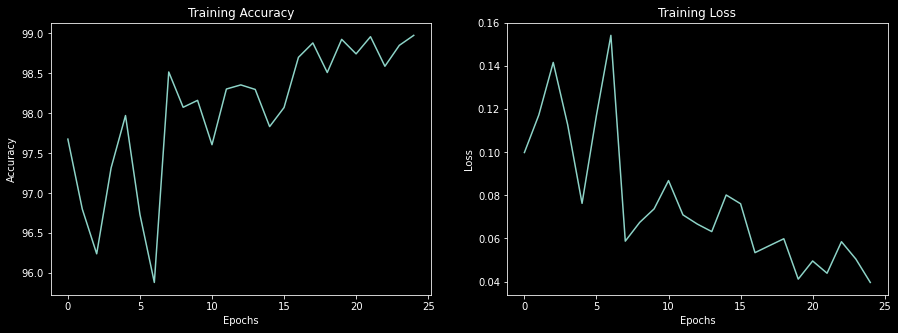

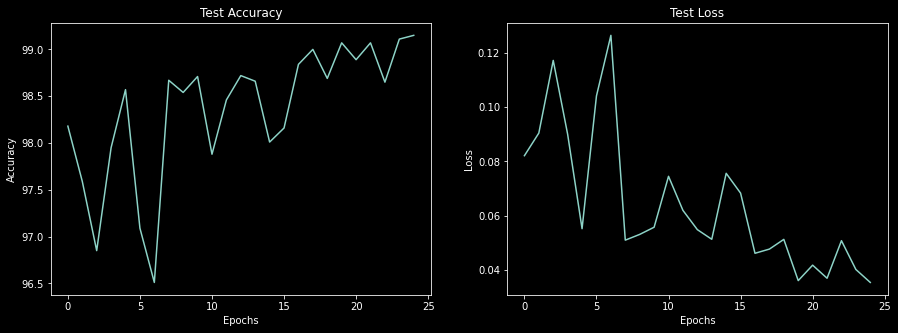

In [10]:
# Import the functions to plot the results
import visualize; reload (visualize)

# Plot the training accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[training_accuracy, training_losses],
    mode='training'
)

# Plot the test accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[test_accuracy, test_losses],
    mode='test'
)

<a name='bn_miss_img'></a>
#### Misclassified Images

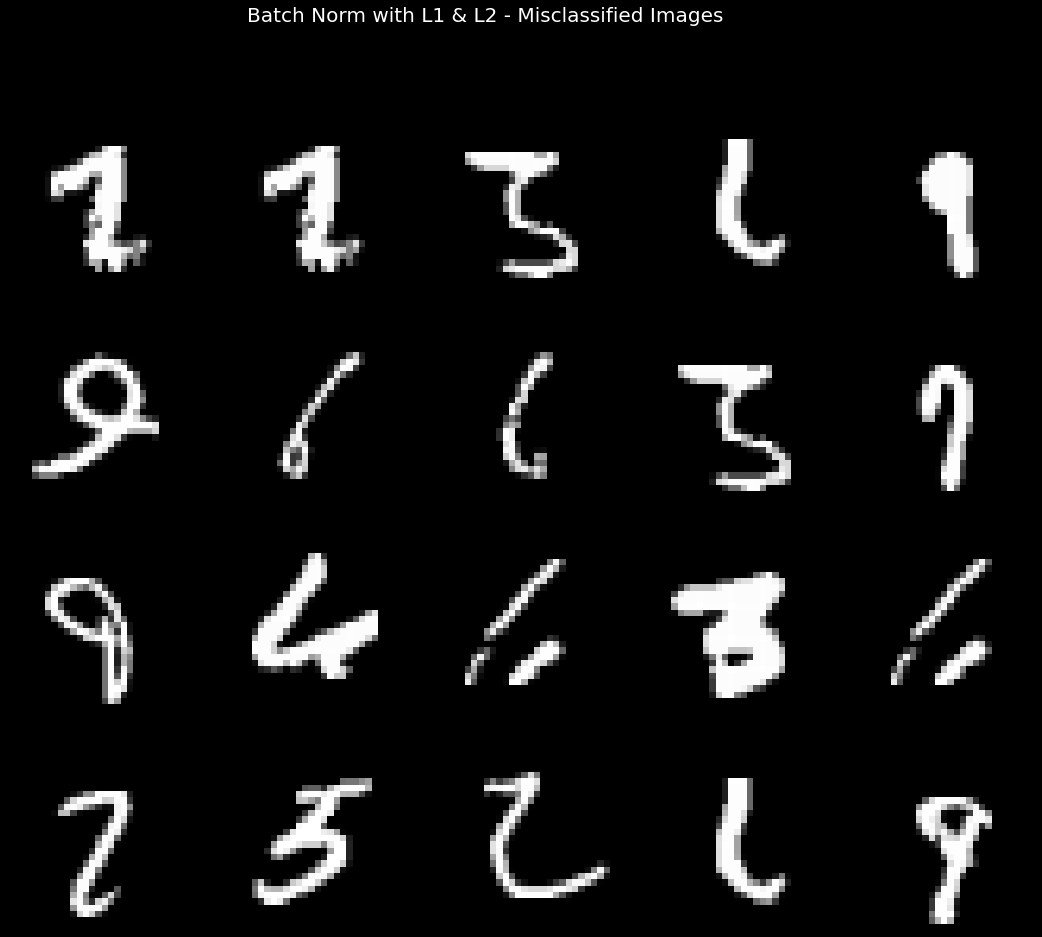

In [11]:
import visualize; reload (visualize)

# Get a list of random indicies
random_idx = torch.randint (0, len (misclassified_images), size=(1, 20))

# Display the images
fig_title = " ".join (normalization.split ("_")).title ()
if regularization:
    fig_title += ' with ' + ' & '.join (regularization.split ('_')).title ()
    
visualize.display_results (
    list (misclassified_images [random_idx].reshape (20, 28, 28).cpu ().data.numpy ()), 
    nrows_ncols=(4, 5), image_r_plot='image',
    fig_title=f'{fig_title} - Misclassified Images'
)

**Note:** _The performance of all the models are [consolidated](#consolidated) at the end_

## Model using Group Normalization
Group Normalization with L1 Regularization

|![group_norm](../../Images/markdown_images/group_norm.png)|
|:---:|
|_Group Normalization[1](#references)_|

In [12]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
from torchsummary import summary

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the dropout_percentage
dropout_percentage = 0.01

# Normalization strategy
# one of 'group_norm', 'layer_norm', 
# 'batch_norm' or 'instance_norm'
# Tying out instance norm just to see how it works
normalization = 'group_norm'

# Import the class with the network architecture
import model; reload (model)

# Create a model object
custom_model = model.MNISTNet (
    drop_perc=dropout_percentage,
    normalization=normalization
).to (device)
summary(custom_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
         GroupNorm-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]             128
            Conv2d-6            [-1, 8, 24, 24]             576
         GroupNorm-7            [-1, 8, 24, 24]              16
              ReLU-8            [-1, 8, 24, 24]               0
           Dropout-9            [-1, 8, 24, 24]               0
           Conv2d-10           [-1, 16, 24, 24]           1,152
        GroupNorm-11           [-1, 16, 24, 24]              32
             ReLU-12           [-1, 16, 24, 24]               0
          Dropout-13           [-1, 16, 24, 24]               0
        MaxPool2d-14           [-1, 16,

### Train and Validate

In [13]:
# Initialize the model instance
custom_model = model.MNISTNet(
    drop_perc=dropout_percentage,
    normalization=normalization
).to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 

# Have the learning rate initially so that it gets to the region of the global minima
# faster and then reduce it so the it converges slowly to the required minima
# This should avoid falling into local minima
optimizer = optim.SGD (custom_model.parameters(), lr=0.04, momentum=0.9)

# Define a learning rate scheduler
# Refered from: https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
# and https://pytorch.org/docs/master/optim.html
# https://pytorch.org/docs/master/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
# Decrease the learning rate after a particular step
plat_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', 
    factor=0.8, patience=1, 
    min_lr=0.0001, threshold=0.001, 
    verbose=True)

# Reduce the Learning Rate at the specified iteration
# Choose this is based on the previous runs
multistep_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[25], 
    gamma=0.5, verbose=True)

# Train the model for n epochs
epochs = 25

# Regularization
# Either 'None', 'l1', 'l2' or 'l1_l2'
regularization = 'l1'
l1_lambda = 0.0001

# Store the training accuracy and losses
training_accuracy = []
training_losses = []

# Store the test accuracy and losses
test_accuracy = []
test_losses = []

for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    accuracy, loss, _ = model.train (
        custom_model, device, 
        train_loader, optimizer,
        scheduler=multistep_scheduler,
        regularization=regularization, # Regularization
        l1_lambda=l1_lambda, # L1 lambda
    )
    
    # Add it to the list
    # Accuracy and losses are computed 
    # on every batch during training
    training_accuracy.append (accuracy)
    training_losses.append (loss)

    # Validate the results on the test/validation set
    accuracy, loss, misclassified_images = model.test (
        custom_model, 
        device, 
        test_loader
    )

    # Add it to the list
    # The accuracy and loss are computed on the entire
    # test data, so will return a single value
    test_accuracy.append (accuracy)
    test_losses.append (loss)

    # Reduce the learning rate if the loss has plateaued
    plat_scheduler.step (loss)

print (f'Best Model had a Training Accuracy of {np.max (training_accuracy):.2f}', 
        f'& a Test Accuracy of {np.max (test_accuracy):.2f}')

# Update the model log
model_logs [normalization] ['misclassified_images'] = misclassified_images
model_logs [normalization] ['training_accuracy'] = training_accuracy
model_logs [normalization] ['training_losses'] = training_losses
model_logs [normalization] ['test_accuracy'] = test_accuracy
model_logs [normalization] ['test_losses'] = test_losses

  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0000e-02.
Iteration 1


Loss=0.1973; Accuracy=82.22; Learning Rate=0.0400: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.1237; Accuracy=57770/60000 (96.28%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1044; Accuracy=9672/10000 (96.72%)


Iteration 2


Loss=0.1959; Accuracy=96.85; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.0834; Accuracy=58485/60000 (97.47%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0698; Accuracy=9801/10000 (98.01%)


Iteration 3


Loss=0.0922; Accuracy=97.71; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.0521; Accuracy=59015/60000 (98.36%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0414; Accuracy=9860/10000 (98.60%)


Iteration 4


Loss=0.1344; Accuracy=97.82; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.0548; Accuracy=58964/60000 (98.27%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0476; Accuracy=9845/10000 (98.45%)


Iteration 5


Loss=0.1155; Accuracy=98.09; Learning Rate=0.0400: 100%|██████████| 469/469 [00:32<00:00, 14.65it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.0452; Accuracy=59152/60000 (98.59%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0369; Accuracy=9877/10000 (98.77%)


Iteration 6


Loss=0.1008; Accuracy=98.28; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.0569; Accuracy=58945/60000 (98.24%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0416; Accuracy=9871/10000 (98.71%)


Iteration 7


Loss=0.1237; Accuracy=98.21; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.0543; Accuracy=58940/60000 (98.23%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0481; Accuracy=9833/10000 (98.33%)


Epoch     7: reducing learning rate of group 0 to 3.2000e-02.
Iteration 8


Loss=0.1226; Accuracy=98.55; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.0338; Accuracy=59374/60000 (98.96%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0296; Accuracy=9913/10000 (99.13%)


Iteration 9


Loss=0.1751; Accuracy=98.61; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.0419; Accuracy=59197/60000 (98.66%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0315; Accuracy=9892/10000 (98.92%)


Iteration 10


Loss=0.1620; Accuracy=98.63; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.0350; Accuracy=59334/60000 (98.89%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0305; Accuracy=9916/10000 (99.16%)


Epoch    10: reducing learning rate of group 0 to 2.5600e-02.
Iteration 11


Loss=0.1192; Accuracy=98.70; Learning Rate=0.0256: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.0379; Accuracy=59280/60000 (98.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0302; Accuracy=9902/10000 (99.02%)


Iteration 12


Loss=0.0845; Accuracy=98.77; Learning Rate=0.0256: 100%|██████████| 469/469 [00:31<00:00, 14.94it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.0309; Accuracy=59439/60000 (99.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0280; Accuracy=9916/10000 (99.16%)


Iteration 13


Loss=0.0816; Accuracy=98.75; Learning Rate=0.0256: 100%|██████████| 469/469 [00:31<00:00, 14.97it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.0364; Accuracy=59282/60000 (98.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0342; Accuracy=9894/10000 (98.94%)


Iteration 14


Loss=0.1597; Accuracy=98.68; Learning Rate=0.0256: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.0405; Accuracy=59216/60000 (98.69%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0352; Accuracy=9890/10000 (98.90%)


Epoch    14: reducing learning rate of group 0 to 2.0480e-02.
Iteration 15


Loss=0.1291; Accuracy=98.89; Learning Rate=0.0205: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.0285; Accuracy=59454/60000 (99.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0270; Accuracy=9923/10000 (99.23%)


Iteration 16


Loss=0.1291; Accuracy=98.99; Learning Rate=0.0205: 100%|██████████| 469/469 [00:31<00:00, 14.86it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.0338; Accuracy=59366/60000 (98.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0290; Accuracy=9903/10000 (99.03%)


Iteration 17


Loss=0.0799; Accuracy=98.89; Learning Rate=0.0205: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.0288; Accuracy=59479/60000 (99.13%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0243; Accuracy=9921/10000 (99.21%)


Iteration 18


Loss=0.1378; Accuracy=98.88; Learning Rate=0.0205: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.0301; Accuracy=59447/60000 (99.08%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0265; Accuracy=9921/10000 (99.21%)


Iteration 19


Loss=0.0843; Accuracy=98.86; Learning Rate=0.0205: 100%|██████████| 469/469 [00:31<00:00, 14.94it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.0318; Accuracy=59404/60000 (99.01%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0295; Accuracy=9906/10000 (99.06%)


Epoch    19: reducing learning rate of group 0 to 1.6384e-02.
Iteration 20


Loss=0.1510; Accuracy=99.04; Learning Rate=0.0164: 100%|██████████| 469/469 [00:31<00:00, 14.87it/s]

Adjusting learning rate of group 0 to 1.6384e-02.



Train set: Loss=0.0248; Accuracy=59511/60000 (99.19%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0208; Accuracy=9928/10000 (99.28%)


Iteration 21


Loss=0.0759; Accuracy=98.99; Learning Rate=0.0164: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s]

Adjusting learning rate of group 0 to 1.6384e-02.



Train set: Loss=0.0276; Accuracy=59465/60000 (99.11%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0246; Accuracy=9924/10000 (99.24%)


Iteration 22


Loss=0.0760; Accuracy=99.02; Learning Rate=0.0164: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

Adjusting learning rate of group 0 to 1.6384e-02.



Train set: Loss=0.0349; Accuracy=59319/60000 (98.86%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0286; Accuracy=9906/10000 (99.06%)


Epoch    22: reducing learning rate of group 0 to 1.3107e-02.
Iteration 23


Loss=0.0714; Accuracy=99.13; Learning Rate=0.0131: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s]

Adjusting learning rate of group 0 to 1.3107e-02.



Train set: Loss=0.0279; Accuracy=59464/60000 (99.11%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0254; Accuracy=9921/10000 (99.21%)


Iteration 24


Loss=0.0679; Accuracy=99.12; Learning Rate=0.0131: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]

Adjusting learning rate of group 0 to 1.3107e-02.



Train set: Loss=0.0215; Accuracy=59603/60000 (99.34%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0195; Accuracy=9939/10000 (99.39%)


Iteration 25


Loss=0.0740; Accuracy=99.15; Learning Rate=0.0131: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s]

Adjusting learning rate of group 0 to 6.5536e-03.



Train set: Loss=0.0256; Accuracy=59509/60000 (99.18%)



Test set: Loss=0.0218; Accuracy=9932/10000 (99.32%)


Best Model had a Training Accuracy of 99.34 & a Test Accuracy of 99.39


### Plot Results

#### Accuracy and Losses

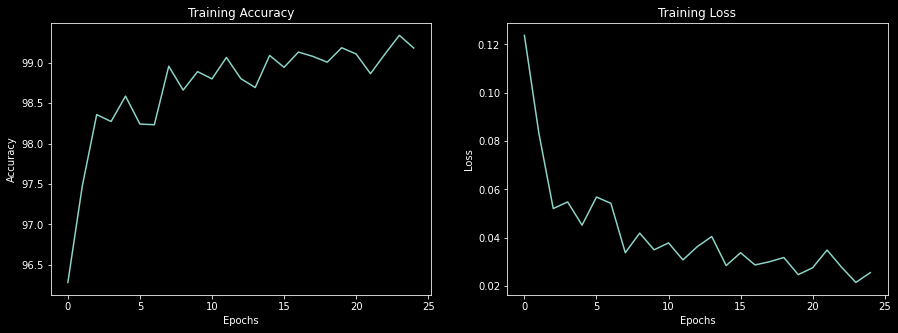

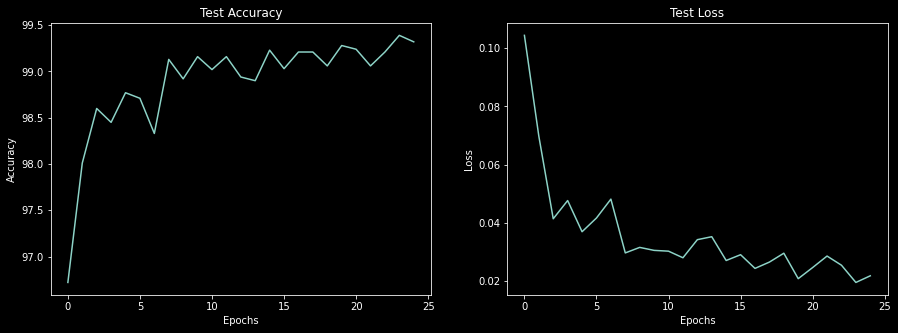

In [14]:
# Import the functions to plot the results
import visualize; reload (visualize)

# Plot the training accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[training_accuracy, training_losses],
    mode='training'
)

# Plot the test accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[test_accuracy, test_losses],
    mode='test'
)

<a name='gn_miss_img'></a>
#### Misclassified Images

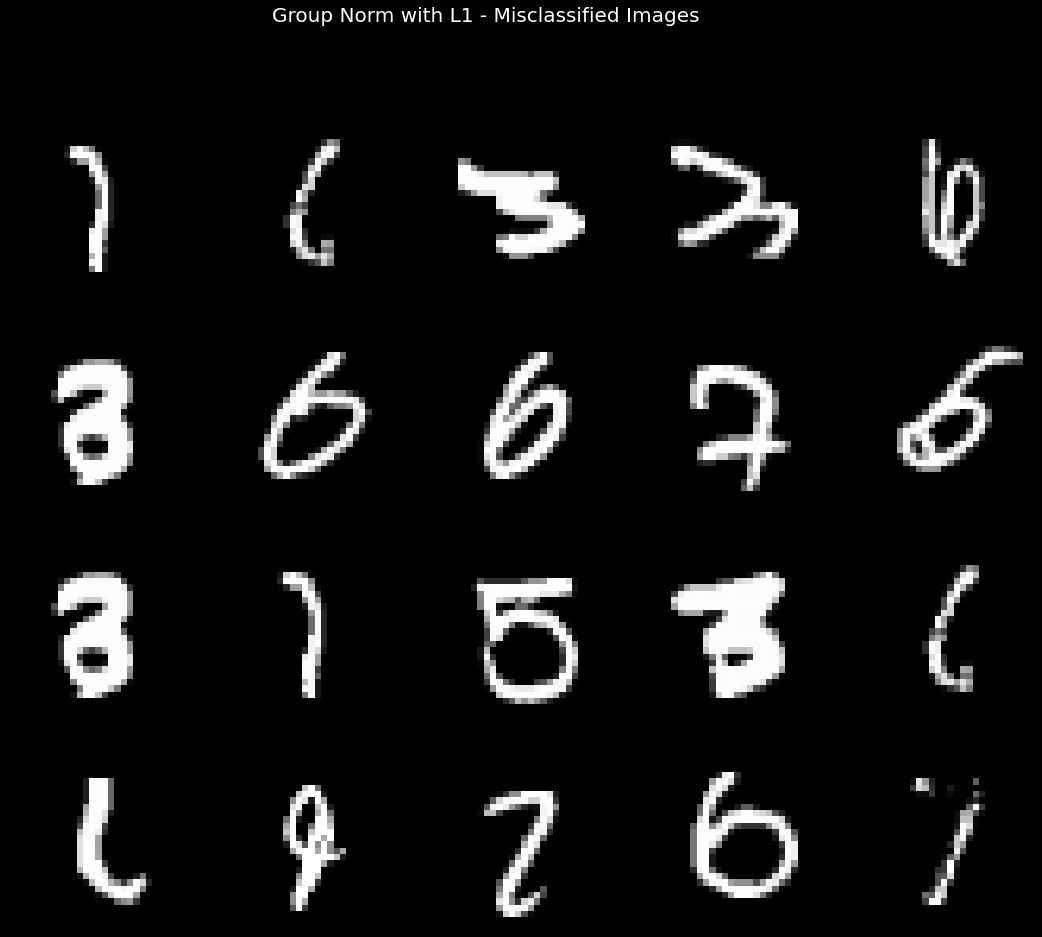

In [15]:
import visualize; reload (visualize)

# Get a list of random indicies
random_idx = torch.randint (0, len (misclassified_images), size=(1, 20))

# Display the images
fig_title = " ".join (normalization.split ("_")).title ()
if regularization:
    fig_title += ' with ' + ' & '.join (regularization.split ('_')).title ()
    
visualize.display_results (
    list (misclassified_images [random_idx].reshape (20, 28, 28).cpu ().data.numpy ()), 
    nrows_ncols=(4, 5), image_r_plot='image',
    fig_title=f'{fig_title} - Misclassified Images'
)

**Note:** _The performance of all the models are [consolidated](#consolidated) at the end_

## Model using Layer Normalization
- Layer Normalization with L2 Regularization
- Using Layer Norm adds a lot of parameters, since its normalized on (Channels, Height, Width) ([2](#references))

|![layer_norm](../../Images/markdown_images/layer_norm.png)|
|:---:|
|_Layer Normalization[1](#references)_|

In [16]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
from torchsummary import summary

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the dropout_percentage
dropout_percentage = 0.01

# Normalization strategy
# one of 'group_norm', 'layer_norm', 
# 'batch_norm' or 'instance_norm'
# Tying out instance norm just to see how it works
normalization = 'layer_norm'

# Import the class with the network architecture
import model; reload (model)

# Create a model object
custom_model = model.MNISTNet (
    drop_perc=dropout_percentage,
    normalization=normalization
).to (device)
summary(custom_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
         LayerNorm-2           [-1, 16, 26, 26]          21,632
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]             128
            Conv2d-6            [-1, 8, 24, 24]             576
         LayerNorm-7            [-1, 8, 24, 24]           9,216
              ReLU-8            [-1, 8, 24, 24]               0
           Dropout-9            [-1, 8, 24, 24]               0
           Conv2d-10           [-1, 16, 24, 24]           1,152
        LayerNorm-11           [-1, 16, 24, 24]          18,432
             ReLU-12           [-1, 16, 24, 24]               0
          Dropout-13           [-1, 16, 24, 24]               0
        MaxPool2d-14           [-1, 16,

**Note:** _There's an increase in the number of parameters, which is caused due the normalization layer_

### Train and Validate

In [17]:
# Initialize the model instance
custom_model = model.MNISTNet(
    drop_perc=dropout_percentage,
    normalization=normalization
).to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 

# Have the learning rate initially so that it gets to the region of the global minima
# faster and then reduce it so the it converges slowly to the required minima
# This should avoid falling into local minima
optimizer = optim.SGD (custom_model.parameters(), lr=0.04, momentum=0.9)

# Define a learning rate scheduler
# Refered from: https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
# and https://pytorch.org/docs/master/optim.html
# https://pytorch.org/docs/master/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
# Decrease the learning rate after a particular step
plat_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', 
    factor=0.8, patience=1, 
    min_lr=0.0001, threshold=0.001, 
    verbose=True)

# Reduce the Learning Rate at the specified iteration
# Choose this is based on the previous runs
multistep_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[25], 
    gamma=0.5, verbose=True)

# Train the model for n epochs
epochs = 25

# Regularization
# Either 'None', 'l1', 'l2' or 'l1_l2'
regularization = 'l2'
l2_lambda = 0.001

# Store the training accuracy and losses
training_accuracy = []
training_losses = []

# Store the test accuracy and losses
test_accuracy = []
test_losses = []

for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    accuracy, loss, _ = model.train (
        custom_model, device, 
        train_loader, optimizer,
        scheduler=multistep_scheduler,
        regularization=regularization, # Regularization
        l2_lambda=l2_lambda # L2 lambdas
    )
    
    # Add it to the list
    # Accuracy and losses are computed 
    # on every batch during training
    training_accuracy.append (accuracy)
    training_losses.append (loss)

    # Validate the results on the test/validation set
    accuracy, loss, misclassified_images = model.test (
        custom_model, 
        device, 
        test_loader
    )

    # Add it to the list
    # The accuracy and loss are computed on the entire
    # test data, so will return a single value
    test_accuracy.append (accuracy)
    test_losses.append (loss)

    # Reduce the learning rate if the loss has plateaued
    plat_scheduler.step (loss)

print (f'Best Model had a Training Accuracy of {np.max (training_accuracy):.2f}', 
        f'& a Test Accuracy of {np.max (test_accuracy):.2f}')

# Update the model log
model_logs [normalization] ['misclassified_images'] = misclassified_images
model_logs [normalization] ['training_accuracy'] = training_accuracy
model_logs [normalization] ['training_losses'] = training_losses
model_logs [normalization] ['test_accuracy'] = test_accuracy
model_logs [normalization] ['test_losses'] = test_losses

  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0000e-02.
Iteration 1


Loss=14.0821; Accuracy=78.97; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 15.09it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.2137; Accuracy=57223/60000 (95.37%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1870; Accuracy=9605/10000 (96.05%)


Iteration 2


Loss=6.7920; Accuracy=95.90; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 15.06it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.1568; Accuracy=57882/60000 (96.47%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1388; Accuracy=9695/10000 (96.95%)


Iteration 3


Loss=3.3247; Accuracy=97.12; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 15.06it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.1041; Accuracy=58787/60000 (97.98%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0915; Accuracy=9810/10000 (98.10%)


Iteration 4


Loss=1.7284; Accuracy=97.72; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.1005; Accuracy=58856/60000 (98.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0851; Accuracy=9855/10000 (98.55%)


Iteration 5


Loss=1.0096; Accuracy=97.73; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.1023; Accuracy=58780/60000 (97.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0901; Accuracy=9817/10000 (98.17%)


Iteration 6


Loss=0.6608; Accuracy=97.66; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 15.04it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.1077; Accuracy=58765/60000 (97.94%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0919; Accuracy=9845/10000 (98.45%)


Epoch     6: reducing learning rate of group 0 to 3.2000e-02.
Iteration 7


Loss=0.4831; Accuracy=97.77; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 15.05it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.1098; Accuracy=58780/60000 (97.97%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1005; Accuracy=9800/10000 (98.00%)


Iteration 8


Loss=0.5214; Accuracy=97.69; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.1201; Accuracy=58479/60000 (97.47%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1063; Accuracy=9763/10000 (97.63%)


Epoch     8: reducing learning rate of group 0 to 2.5600e-02.
Iteration 9


Loss=0.3937; Accuracy=97.85; Learning Rate=0.0256: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.0953; Accuracy=58856/60000 (98.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0885; Accuracy=9825/10000 (98.25%)


Iteration 10


Loss=0.3936; Accuracy=97.79; Learning Rate=0.0256: 100%|██████████| 469/469 [00:31<00:00, 15.03it/s]

Adjusting learning rate of group 0 to 2.5600e-02.



Train set: Loss=0.1105; Accuracy=58614/60000 (97.69%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.1014; Accuracy=9787/10000 (97.87%)


Epoch    10: reducing learning rate of group 0 to 2.0480e-02.
Iteration 11


Loss=0.3314; Accuracy=97.91; Learning Rate=0.0205: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.1044; Accuracy=58839/60000 (98.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0970; Accuracy=9821/10000 (98.21%)


Iteration 12


Loss=0.3473; Accuracy=97.99; Learning Rate=0.0205: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s]

Adjusting learning rate of group 0 to 2.0480e-02.



Train set: Loss=0.0965; Accuracy=58900/60000 (98.17%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0901; Accuracy=9827/10000 (98.27%)


Epoch    12: reducing learning rate of group 0 to 1.6384e-02.
Iteration 13


Loss=0.3095; Accuracy=98.11; Learning Rate=0.0164: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s]

Adjusting learning rate of group 0 to 1.6384e-02.



Train set: Loss=0.0823; Accuracy=59134/60000 (98.56%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0761; Accuracy=9866/10000 (98.66%)


Iteration 14


Loss=0.3637; Accuracy=98.22; Learning Rate=0.0164: 100%|██████████| 469/469 [00:31<00:00, 15.03it/s]

Adjusting learning rate of group 0 to 1.6384e-02.



Train set: Loss=0.0922; Accuracy=58936/60000 (98.23%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0852; Accuracy=9829/10000 (98.29%)


Iteration 15


Loss=0.3477; Accuracy=98.00; Learning Rate=0.0164: 100%|██████████| 469/469 [00:31<00:00, 15.00it/s]

Adjusting learning rate of group 0 to 1.6384e-02.



Train set: Loss=0.0896; Accuracy=59019/60000 (98.36%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0861; Accuracy=9850/10000 (98.50%)


Epoch    15: reducing learning rate of group 0 to 1.3107e-02.
Iteration 16


Loss=0.3449; Accuracy=98.24; Learning Rate=0.0131: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s]

Adjusting learning rate of group 0 to 1.3107e-02.



Train set: Loss=0.0977; Accuracy=58911/60000 (98.19%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0917; Accuracy=9818/10000 (98.18%)


Iteration 17


Loss=0.4027; Accuracy=98.34; Learning Rate=0.0131: 100%|██████████| 469/469 [00:31<00:00, 14.96it/s]

Adjusting learning rate of group 0 to 1.3107e-02.



Train set: Loss=0.0804; Accuracy=59125/60000 (98.54%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0748; Accuracy=9864/10000 (98.64%)


Iteration 18


Loss=0.2982; Accuracy=98.33; Learning Rate=0.0131: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s]

Adjusting learning rate of group 0 to 1.3107e-02.



Train set: Loss=0.0881; Accuracy=58967/60000 (98.28%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0856; Accuracy=9822/10000 (98.22%)


Iteration 19


Loss=0.3305; Accuracy=98.43; Learning Rate=0.0131: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

Adjusting learning rate of group 0 to 1.3107e-02.



Train set: Loss=0.0773; Accuracy=59219/60000 (98.70%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0759; Accuracy=9861/10000 (98.61%)


Epoch    19: reducing learning rate of group 0 to 1.0486e-02.
Iteration 20


Loss=0.3274; Accuracy=98.45; Learning Rate=0.0105: 100%|██████████| 469/469 [00:31<00:00, 14.97it/s]

Adjusting learning rate of group 0 to 1.0486e-02.



Train set: Loss=0.0743; Accuracy=59247/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0705; Accuracy=9883/10000 (98.83%)


Iteration 21


Loss=0.2826; Accuracy=98.45; Learning Rate=0.0105: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s]

Adjusting learning rate of group 0 to 1.0486e-02.



Train set: Loss=0.0865; Accuracy=59005/60000 (98.34%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0839; Accuracy=9833/10000 (98.33%)


Iteration 22


Loss=0.2869; Accuracy=98.40; Learning Rate=0.0105: 100%|██████████| 469/469 [00:31<00:00, 14.95it/s]

Adjusting learning rate of group 0 to 1.0486e-02.



Train set: Loss=0.0684; Accuracy=59387/60000 (98.98%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0677; Accuracy=9888/10000 (98.88%)


Iteration 23


Loss=0.3312; Accuracy=98.47; Learning Rate=0.0105: 100%|██████████| 469/469 [00:31<00:00, 14.82it/s]

Adjusting learning rate of group 0 to 1.0486e-02.



Train set: Loss=0.0752; Accuracy=59251/60000 (98.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0736; Accuracy=9871/10000 (98.71%)


Iteration 24


Loss=0.3110; Accuracy=98.43; Learning Rate=0.0105: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

Adjusting learning rate of group 0 to 1.0486e-02.



Train set: Loss=0.0773; Accuracy=59164/60000 (98.61%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0762; Accuracy=9859/10000 (98.59%)


Epoch    24: reducing learning rate of group 0 to 8.3886e-03.
Iteration 25


Loss=0.3642; Accuracy=98.59; Learning Rate=0.0084: 100%|██████████| 469/469 [00:32<00:00, 14.39it/s]

Adjusting learning rate of group 0 to 4.1943e-03.



Train set: Loss=0.0667; Accuracy=59412/60000 (99.02%)



Test set: Loss=0.0679; Accuracy=9895/10000 (98.95%)


Best Model had a Training Accuracy of 99.02 & a Test Accuracy of 98.95


### Plot Results

#### Accuracy and Losses

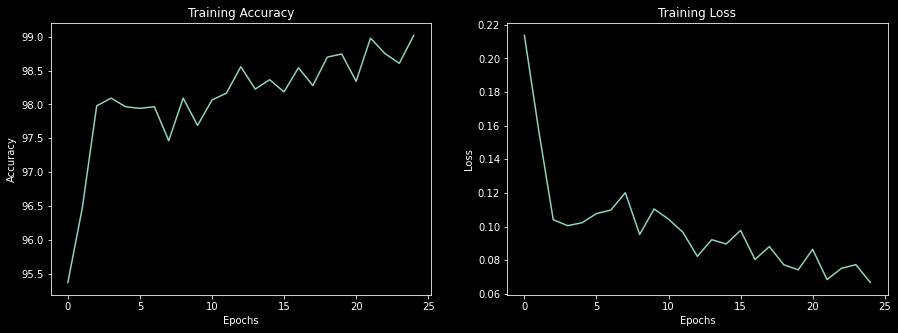

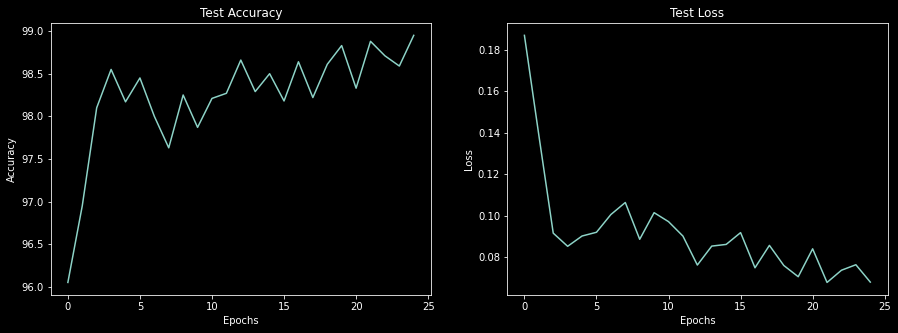

In [18]:
# Import the functions to plot the results
import visualize; reload (visualize)

# Plot the training accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[training_accuracy, training_losses],
    mode='training'
)

# Plot the test accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[test_accuracy, test_losses],
    mode='test'
)

<a name='ln_miss_img'></a>
#### Misclassified Images

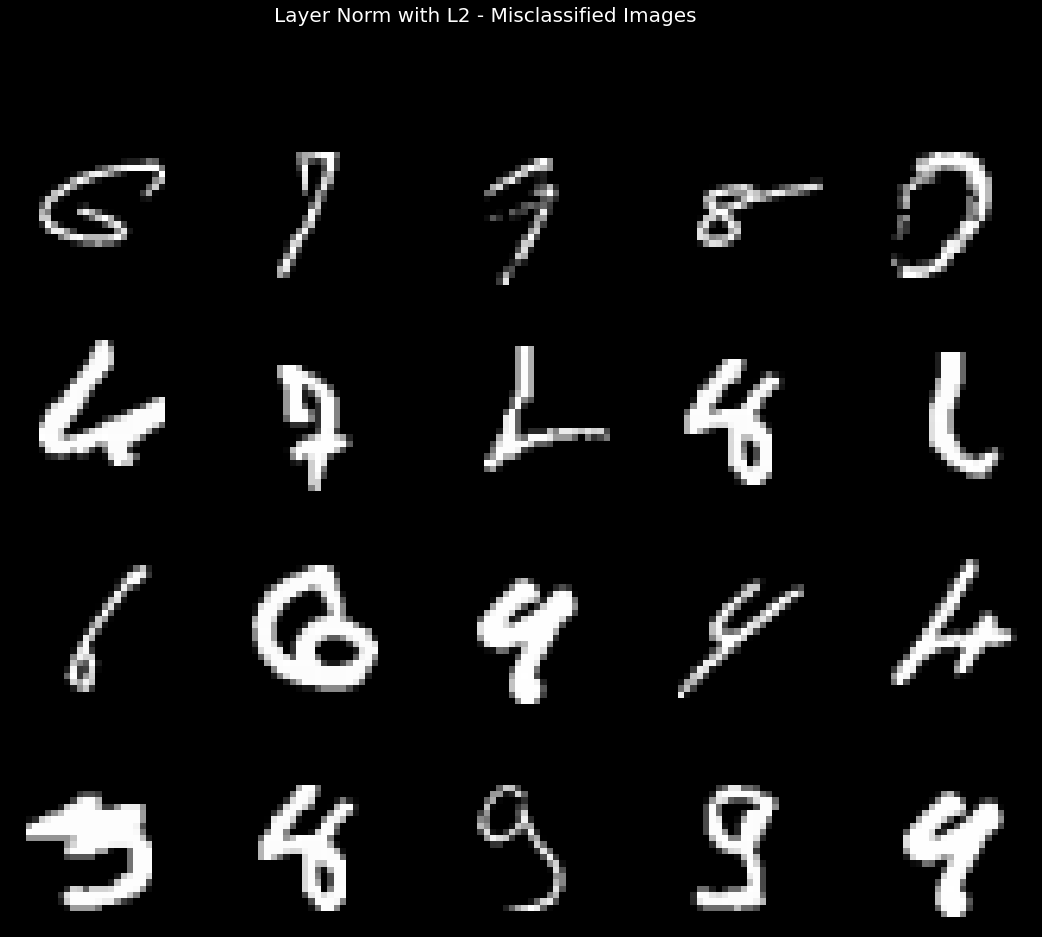

In [19]:
import visualize; reload (visualize)

# Get a list of random indicies
random_idx = torch.randint (0, len (misclassified_images), size=(1, 20))

# Display the images
fig_title = " ".join (normalization.split ("_")).title ()
if regularization:
    fig_title += ' with ' + ' & '.join (regularization.split ('_')).title ()
    
visualize.display_results (
    list (misclassified_images [random_idx].reshape (20, 28, 28).cpu ().data.numpy ()), 
    nrows_ncols=(4, 5), image_r_plot='image',
    fig_title=f'{fig_title} - Misclassified Images'
)

**Note:** _The performance of all the models are [consolidated](#consolidated) at the end_

## Model using Instance Normalization
Exploring this as well to see how it stacks up with other normalization techniques

|![instance_norm](../../Images/markdown_images/instance_norm.png)|
|:---:|
|_Instance Normalization[1](#references)_|

In [20]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
from torchsummary import summary

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the dropout_percentage
dropout_percentage = 0.01

# Normalization strategy
# one of 'group_norm', 'layer_norm', 
# 'batch_norm' or 'instance_norm'
# Tying out instance norm just to see how it works
normalization = 'instance_norm'

# Import the class with the network architecture
import model; reload (model)

# Create a model object
custom_model = model.MNISTNet (
    drop_perc=dropout_percentage,
    normalization=normalization
).to (device)
summary(custom_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
    InstanceNorm2d-2           [-1, 16, 26, 26]               0
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]             128
            Conv2d-6            [-1, 8, 24, 24]             576
    InstanceNorm2d-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
           Dropout-9            [-1, 8, 24, 24]               0
           Conv2d-10           [-1, 16, 24, 24]           1,152
   InstanceNorm2d-11           [-1, 16, 24, 24]               0
             ReLU-12           [-1, 16, 24, 24]               0
          Dropout-13           [-1, 16, 24, 24]               0
        MaxPool2d-14           [-1, 16,

### Train and Validate

In [21]:
# Initialize the model instance
custom_model = model.MNISTNet(
    drop_perc=dropout_percentage,
    normalization=normalization
).to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 

# Have the learning rate initially so that it gets to the region of the global minima
# faster and then reduce it so the it converges slowly to the required minima
# This should avoid falling into local minima
optimizer = optim.SGD (custom_model.parameters(), lr=0.04, momentum=0.9)

# Define a learning rate scheduler
# Refered from: https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
# and https://pytorch.org/docs/master/optim.html
# https://pytorch.org/docs/master/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
# Decrease the learning rate after a particular step
plat_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', 
    factor=0.8, patience=1, 
    min_lr=0.0001, threshold=0.001, 
    verbose=True)

# Reduce the Learning Rate at the specified iteration
# Choose this is based on the previous runs
multistep_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[25], 
    gamma=0.5, verbose=True)

# Train the model for n epochs
epochs = 25

# Regularization
# Either 'None', 'l1', 'l2' or 'l1_l2'
regularization = 'l1_l2'
l1_lambda = 0.0001
l2_lambda = 0.001

# Store the training accuracy and losses
training_accuracy = []
training_losses = []

# Store the test accuracy and losses
test_accuracy = []
test_losses = []

for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    accuracy, loss, _ = model.train (
        custom_model, device, 
        train_loader, optimizer,
        scheduler=multistep_scheduler,
        regularization=regularization, # Regularization
        l1_lambda=l1_lambda, l2_lambda=l2_lambda # L1 and L2 lambdas
    )
    
    # Add it to the list
    # Accuracy and losses are computed 
    # on every batch during training
    training_accuracy.append (accuracy)
    training_losses.append (loss)

    # Validate the results on the test/validation set
    accuracy, loss, misclassified_images = model.test (
        custom_model, 
        device, 
        test_loader
    )

    # Add it to the list
    # The accuracy and loss are computed on the entire
    # test data, so will return a single value
    test_accuracy.append (accuracy)
    test_losses.append (loss)

    # Reduce the learning rate if the loss has plateaued
    plat_scheduler.step (loss)

print (f'Best Model had a Training Accuracy of {np.max (training_accuracy):.2f}', 
        f'& a Test Accuracy of {np.max (test_accuracy):.2f}')

# Update the model log
model_logs [normalization] ['misclassified_images'] = misclassified_images
model_logs [normalization] ['training_accuracy'] = training_accuracy
model_logs [normalization] ['training_losses'] = training_losses
model_logs [normalization] ['test_accuracy'] = test_accuracy
model_logs [normalization] ['test_losses'] = test_losses

  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0000e-02.
Iteration 1


Loss=1.6893; Accuracy=37.89; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=1.5954; Accuracy=36542/60000 (60.90%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=1.5828; Accuracy=6187/10000 (61.87%)


Iteration 2


Loss=1.4041; Accuracy=65.28; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=1.0988; Accuracy=41754/60000 (69.59%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=1.0862; Accuracy=6919/10000 (69.19%)


Iteration 3


Loss=1.3101; Accuracy=71.98; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.9050; Accuracy=43939/60000 (73.23%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.8880; Accuracy=7322/10000 (73.22%)


Iteration 4


Loss=1.2753; Accuracy=77.69; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.72it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.7843; Accuracy=49839/60000 (83.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.7648; Accuracy=8391/10000 (83.91%)


Iteration 5


Loss=1.0783; Accuracy=83.69; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.6495; Accuracy=52716/60000 (87.86%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.6271; Accuracy=8901/10000 (89.01%)


Iteration 6


Loss=1.1543; Accuracy=85.58; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.6005; Accuracy=51489/60000 (85.81%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.5812; Accuracy=8640/10000 (86.40%)


Iteration 7


Loss=1.1133; Accuracy=85.86; Learning Rate=0.0400: 100%|██████████| 469/469 [00:30<00:00, 15.34it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.6096; Accuracy=51104/60000 (85.17%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.5823; Accuracy=8603/10000 (86.03%)


Iteration 8


Loss=1.0928; Accuracy=86.10; Learning Rate=0.0400: 100%|██████████| 469/469 [00:30<00:00, 15.38it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.5586; Accuracy=51451/60000 (85.75%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.5368; Accuracy=8648/10000 (86.48%)


Iteration 9


Loss=1.0566; Accuracy=86.42; Learning Rate=0.0400: 100%|██████████| 469/469 [00:30<00:00, 15.37it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.5267; Accuracy=52269/60000 (87.11%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.5054; Accuracy=8774/10000 (87.74%)


Iteration 10


Loss=1.0842; Accuracy=88.04; Learning Rate=0.0400: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.5134; Accuracy=55608/60000 (92.68%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4951; Accuracy=9333/10000 (93.33%)


Iteration 11


Loss=1.0228; Accuracy=91.36; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.80it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.6033; Accuracy=53450/60000 (89.08%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.5804; Accuracy=9002/10000 (90.02%)


Iteration 12


Loss=1.0701; Accuracy=92.69; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.5061; Accuracy=55808/60000 (93.01%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4830; Accuracy=9373/10000 (93.73%)


Iteration 13


Loss=0.9474; Accuracy=93.64; Learning Rate=0.0400: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.4986; Accuracy=56308/60000 (93.85%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4720; Accuracy=9498/10000 (94.98%)


Iteration 14


Loss=1.0242; Accuracy=93.89; Learning Rate=0.0400: 100%|██████████| 469/469 [00:32<00:00, 14.59it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.5066; Accuracy=56394/60000 (93.99%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4834; Accuracy=9490/10000 (94.90%)


Iteration 15


Loss=0.9794; Accuracy=94.32; Learning Rate=0.0400: 100%|██████████| 469/469 [00:32<00:00, 14.48it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.4803; Accuracy=56655/60000 (94.42%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4616; Accuracy=9499/10000 (94.99%)


Iteration 16


Loss=0.9936; Accuracy=94.24; Learning Rate=0.0400: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.4582; Accuracy=57078/60000 (95.13%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4362; Accuracy=9608/10000 (96.08%)


Iteration 17


Loss=0.9609; Accuracy=94.50; Learning Rate=0.0400: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.4893; Accuracy=56409/60000 (94.02%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4655; Accuracy=9466/10000 (94.66%)


Iteration 18


Loss=1.0287; Accuracy=94.38; Learning Rate=0.0400: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]

Adjusting learning rate of group 0 to 4.0000e-02.



Train set: Loss=0.6185; Accuracy=52408/60000 (87.35%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.5832; Accuracy=8899/10000 (88.99%)


Epoch    18: reducing learning rate of group 0 to 3.2000e-02.
Iteration 19


Loss=1.0094; Accuracy=94.79; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.4237; Accuracy=57086/60000 (95.14%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4016; Accuracy=9598/10000 (95.98%)


Iteration 20


Loss=0.9699; Accuracy=94.90; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 15.07it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.4137; Accuracy=57203/60000 (95.34%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.3892; Accuracy=9607/10000 (96.07%)


Iteration 21


Loss=0.9510; Accuracy=94.94; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 14.94it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.3976; Accuracy=57390/60000 (95.65%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.3791; Accuracy=9642/10000 (96.42%)


Iteration 22


Loss=0.9325; Accuracy=94.94; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 15.04it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.4200; Accuracy=57362/60000 (95.60%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.3944; Accuracy=9652/10000 (96.52%)


Iteration 23


Loss=0.9109; Accuracy=94.90; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 14.98it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.3993; Accuracy=57635/60000 (96.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.3783; Accuracy=9667/10000 (96.67%)


Iteration 24


Loss=1.0181; Accuracy=95.01; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 15.07it/s]

Adjusting learning rate of group 0 to 3.2000e-02.



Train set: Loss=0.4383; Accuracy=57130/60000 (95.22%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.4168; Accuracy=9614/10000 (96.14%)


Iteration 25


Loss=0.8745; Accuracy=94.93; Learning Rate=0.0320: 100%|██████████| 469/469 [00:31<00:00, 15.11it/s]

Adjusting learning rate of group 0 to 1.6000e-02.



Train set: Loss=0.4074; Accuracy=57351/60000 (95.58%)



Test set: Loss=0.3854; Accuracy=9629/10000 (96.29%)


Epoch    25: reducing learning rate of group 0 to 1.2800e-02.
Best Model had a Training Accuracy of 96.06 & a Test Accuracy of 96.67


### Plot Results

#### Accuracy and Losses

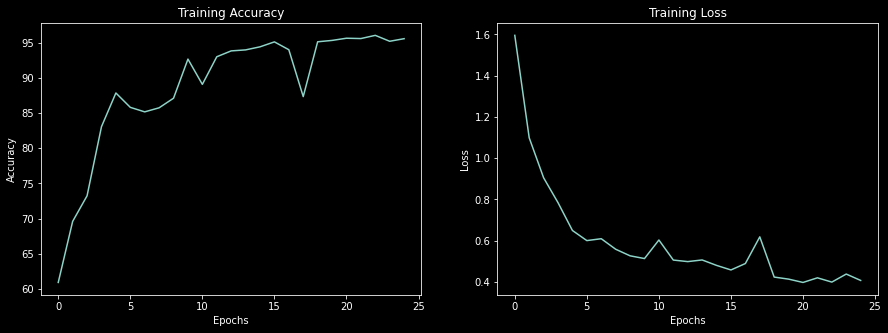

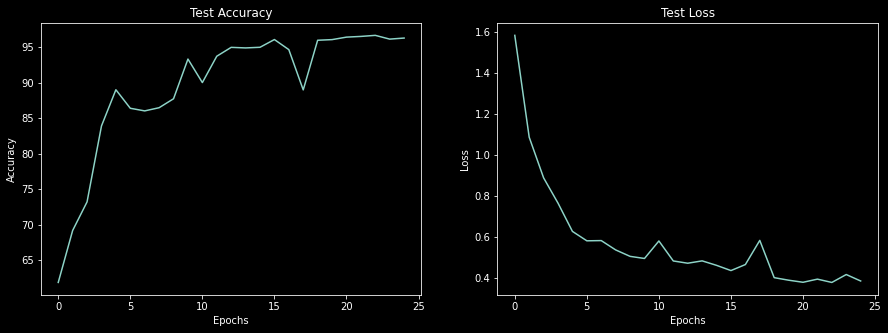

In [22]:
# Import the functions to plot the results
import visualize; reload (visualize)

# Plot the training accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[training_accuracy, training_losses],
    mode='training'
)

# Plot the test accuracy and losses
visualize.plot_accuracy_loss (
    accuracy_loss=[test_accuracy, test_losses],
    mode='test'
)

<a name='in_miss_img'></a>
#### Misclassified Images

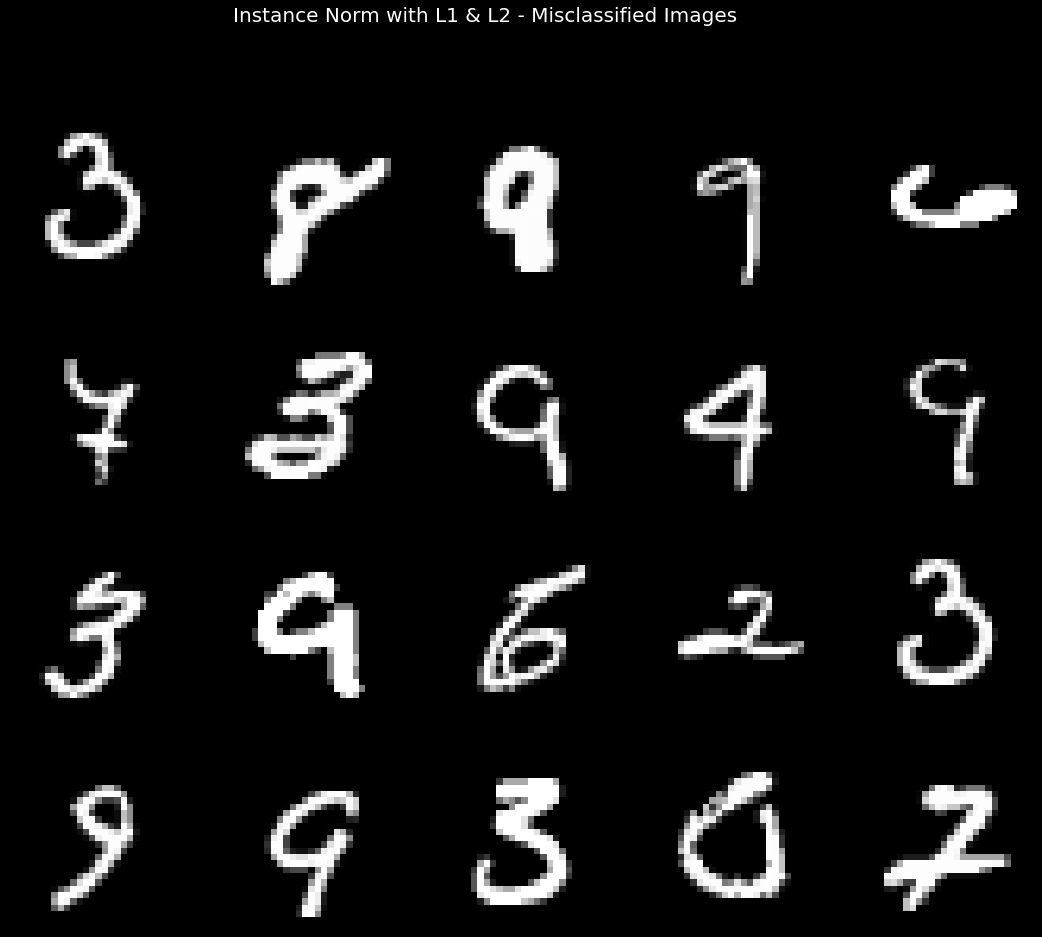

In [27]:
import visualize; reload (visualize)

# Get a list of random indicies
random_idx = torch.randint (0, len (misclassified_images), size=(1, 20))

# Display the images
fig_title = " ".join (normalization.split ("_")).title ()
if regularization:
    fig_title += ' with ' + ' & '.join (regularization.split ('_')).title ()
    
visualize.display_results (
    list (misclassified_images [random_idx].reshape (20, 28, 28).cpu ().data.numpy ()), 
    nrows_ncols=(4, 5), image_r_plot='image',
    fig_title=f'{fig_title} - Misclassified Images'
)


<a name='consolidated'></a>
## Consolidated results

The sections consolidates the results of the models using different normalization techniques

In [41]:
# Get all the required metrics
list_of_accuracies = {'training': [], 'test': []}
list_of_losses = {'training': [], 'test': []}

# Iterate through the logs to get the required values
for norm in ['batch', 'group', 'layer', 'instance']:
    # Get both training and test parameters
    for mode in ['training', 'test']:
        # Accuracies
        list_of_accuracies [mode].append (
            ( model_logs [f'{norm}_norm'] [f'{mode}_accuracy'], f'{norm.title ()} Norm')
        )

        # Losses
        list_of_losses [mode].append (
            (model_logs [f'{norm}_norm'] [f'{mode}_losses'], f'{norm.title ()} Norm')
        )

### Accuracies

<a name='acc_with_in'></a>
#### Comparing Batch Norm, Group Norm, Layer Norm and Instance Norm

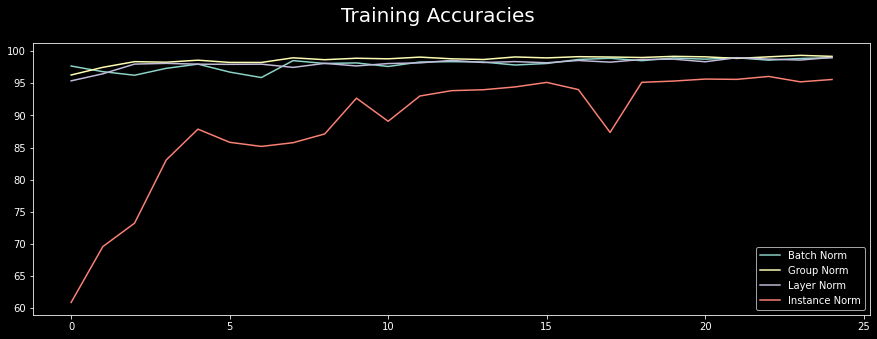

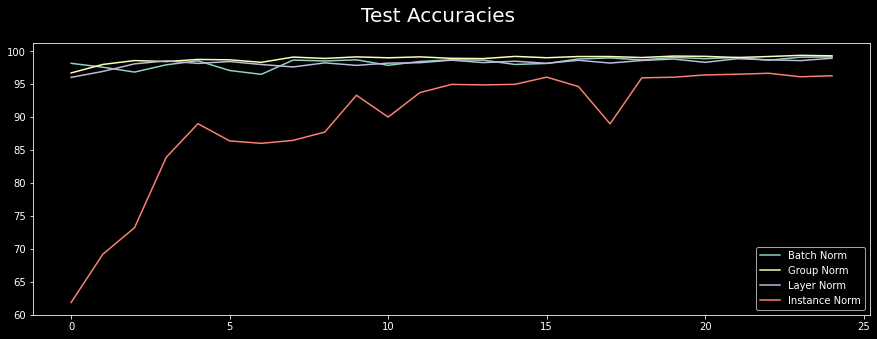

In [44]:
# Plot the training accuracies of the all the models
import visualize; reload (visualize)

visualize.plot_multiple (
    data_points=list_of_accuracies ['training'],
    fig_title='Training Accuracies',
    figsize=(15, 5)
)

# Plot the test accuracies of the all the models
visualize.plot_multiple (
    data_points=list_of_accuracies ['test'],
    fig_title='Test Accuracies',
    figsize=(15, 5)
)

<a name='acc_wo_in'></a>
#### Comparing Batch Norm, Group Norm and Layer Norm

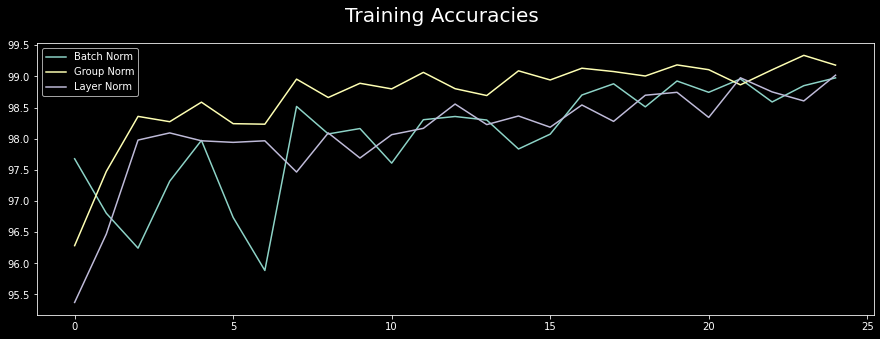

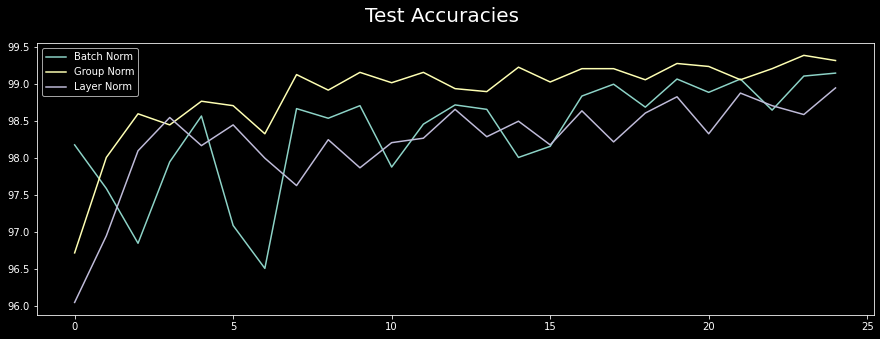

In [46]:
# Plot the training accuracies of the all the models
import visualize; reload (visualize)

visualize.plot_multiple (
    data_points=list_of_accuracies ['training'] [:-1], # Skip Instance Norm
    fig_title='Training Accuracies',
    figsize=(15, 5)
)

# Plot the test accuracies of the all the models
visualize.plot_multiple (
    data_points=list_of_accuracies ['test'] [:-1], # Skip Instance Norm
    fig_title='Test Accuracies',
    figsize=(15, 5)
)

### Losses

<a name='loss_with_in'></a>
#### Comparing Batch Norm, Group Norm, Layer Norm and Instance Norm

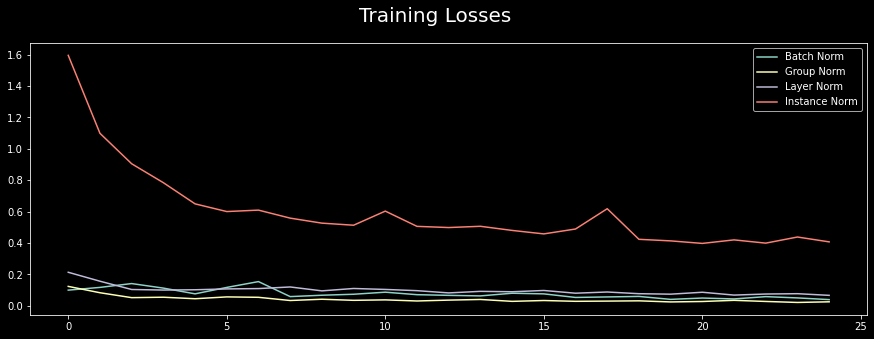

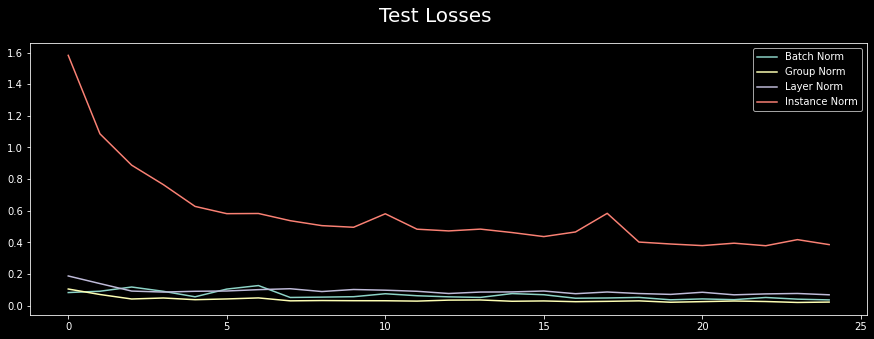

In [45]:
# Plot the training accuracies of the all the models
import visualize; reload (visualize)

visualize.plot_multiple (
    data_points=list_of_losses ['training'],
    fig_title='Training Losses',
    figsize=(15, 5)
)

# Plot the test accuracies of the all the models
visualize.plot_multiple (
    data_points=list_of_losses ['test'],
    fig_title='Test Losses',
    figsize=(15, 5)
)

<a name='loss_wo_in'></a>
#### Comparing Batch Norm, Group Norm and Layer Norm

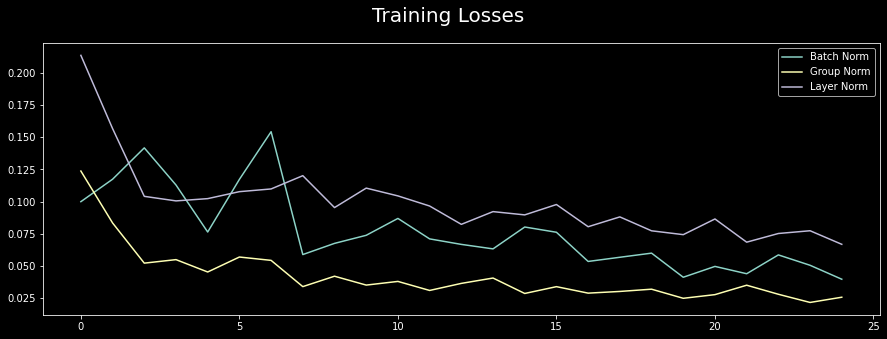

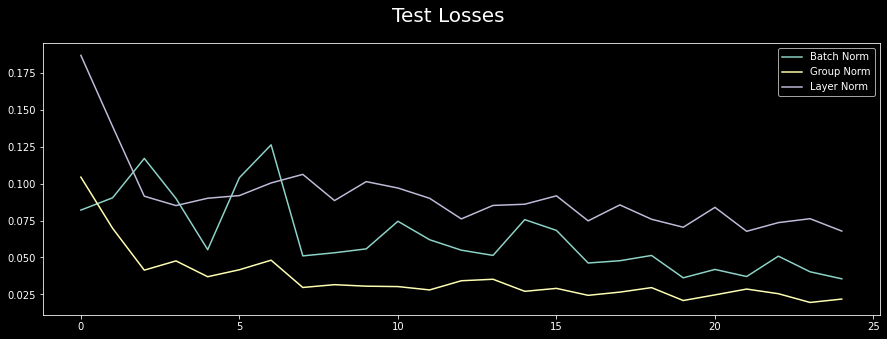

In [47]:
# Plot the training accuracies of the all the models
import visualize; reload (visualize)

visualize.plot_multiple (
    data_points=list_of_losses ['training'] [:-1], # Skip Instance Norm
    fig_title='Training Losses',
    figsize=(15, 5)
)

# Plot the test accuracies of the all the models
visualize.plot_multiple (
    data_points=list_of_losses ['test'] [:-1], # Skip Instance Norm
    fig_title='Test Losses',
    figsize=(15, 5)
)

## Inference

- Based on the plots on [accuracies](#acc_with_in) and [loss](#loss_with_in) comparing Batch, Group, Layer and Instance Normalizaiton, we see instance normalization underperfoming as compared to the other normalization methods
- Comparing the [accuracies](#acc_wo_in) and [loss](#loss_wo_in) of Batch, Group and Layer Normalization (i.e. without Instance Norm), the best accuracy (and correspondingly the least loss) is seen while using _Group Normalization_, followed by Batch Norm and then Layer Norm
    - Although they perform equally well (with a margin of 1-1.5% variation in accuracy), the effect could be due to the difference in regularization methods used
- Training setup used the same [model architecture](./model.py) with the following changes
    - For BN, both L1 and L2 Regularization was used along with a dropout of 0.01
    - For GN, L1 Regularization was used along with a dropout of 0.01
    - For LN, L2 Regularization was use along with a dropout of 0.01
    - For IN, both L1 and L2 Regularization was used along with a dropout of 0.01
- The misclassified images for each of the models are shown in their corresponding sections. In these images, the digits are missing portions or its hard to read.
    - [Misclassified Images - Batch Norm](#bn_miss_img)
    - [Misclassified Images - Group Norm](#gn_miss_img)
    - [Misclassified Images - Layer Norm](#ln_miss_img)
    - [Misclassified Images - Instance Norm](#in_miss_img)

<a name='references'></a>
## References

1. Wu, Y. and He, K., 2018. Group normalization. In Proceedings of the European conference on computer vision (ECCV) (pp. 3-19
2. Future, C. T. B. (2020, August 9). Group Normalization. Committed towards Better Future. https://amaarora.github.io/2020/08/09/groupnorm.html